In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from glob import glob 

import pandas as pd

from fastcore.xtras import load_pickle

from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])
%matplotlib inline

## Load results

In [15]:
all_out = glob("out/**/*.pkl")

In [16]:
all_out = [load_pickle(p) for p in all_out]

In [17]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out: 
    res = {
        'train_size': out['train_size'],
        'frac_valid': out['frac_valid'],
        'accuracy': out['accuracy'],
        'f1_macro': out['f1_macro'],
        'f1_micro': out['f1_micro'],
        'kappa': out['kappa'],
        "num_classes": out['num_classes']
    }

    xgb_res = {
        'train_size': out['train_size'], 
        'accuracy': out['xgboost_baseline']['accuracy'], 
        'f1_macro': out['xgboost_baseline']['f1_macro'],
        'f1_micro': out['xgboost_baseline']['f1_micro'],
        'kappa': out['xgboost_baseline']['kappa'],
        "num_classes": out['num_classes']
    }

    tabpfn_res = {
        'train_size': out['train_size'], 
        'accuracy': out['tabpfn_baseline']['accuracy'], 
        'f1_macro': out['tabpfn_baseline']['f1_macro'],
        'f1_micro': out['tabpfn_baseline']['f1_micro'],
        'kappa': out['tabpfn_baseline']['kappa'],
        "num_classes": out['num_classes']
    }

    extracted_res.append(res)
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [18]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [19]:
grouped_res = res.groupby(['num_classes', 'train_size']).agg(['mean', 'std', 'count'])

In [20]:
grouped_xgboost_res = xgboost_res.groupby(['num_classes', 'train_size']).agg(['mean', 'std', 'count'])

In [21]:
grouped_tabpfn_res = tabpfn_res.groupby(['num_classes', 'train_size']).agg(['mean', 'std', 'count'])

In [22]:
grouped_res.loc[2,:]

frac_valid             accuracy                  f1_macro  \
                 mean  std count      mean       std count      mean   
train_size                                                             
10                1.0  0.0     3  0.556000  0.042332     3  0.495756   
20                1.0  0.0     3  0.666667  0.044242     3  0.651459   
50                1.0  0.0     3  0.774667  0.019732     3  0.773783   
100               1.0  0.0     3  0.900000  0.022271     3  0.899657   
200               1.0  0.0     2  0.926000  0.002828     2  0.925995   
500               1.0  0.0     3  0.934667  0.009238     3  0.934636   

                            f1_micro                     kappa                  
                 std count      mean       std count      mean       std count  
train_size                                                                      
10          0.081415     3  0.556000  0.042332     3  0.112000  0.084664     3  
20          0.066347     3  0.666667  0.044242     3  0.333333  0.088484     3  
50          0.019791     3  0.774667  0.019732     3  0.549333  0.039463     3  
100         0.022630     3  0.900000  0.022271     3  0.800000  0.044542     3  
200         0.002836     2  0.926000  0.002828     2  0.852000  0.005657     2  
500         0.009263     3  0.934667  0.009238     3  0.869333  0.018475     3

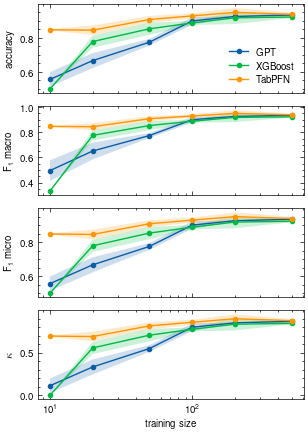

In [23]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex='all')

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
    ax[i].plot(
        grouped_res.loc[2,:].index,
        grouped_res.loc[2,:][metric]['mean'],
        marker='o',
        label='GPT',
    )
    ax[i].fill_between(
        grouped_res.loc[2,:].index,
        grouped_res.loc[2,:][metric]['mean'] - grouped_res.loc[2,:][metric]['std'],
        grouped_res.loc[2,:][metric]['mean'] + grouped_res.loc[2,:][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[2,:].index,
        grouped_xgboost_res.loc[2,:][metric]['mean'],
        marker='o',
        label='XGBoost'
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2,:].index,
        grouped_xgboost_res.loc[2,:][metric]['mean'] - grouped_xgboost_res.loc[2,:][metric]['std'],
        grouped_xgboost_res.loc[2,:][metric]['mean'] + grouped_xgboost_res.loc[2,:][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2,:].index,
        grouped_tabpfn_res.loc[2,:][metric]['mean'],
        marker='o',
        label='TabPFN'
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2,:].index,
        grouped_tabpfn_res.loc[2,:][metric]['mean'] - grouped_tabpfn_res.loc[2,:][metric]['std'],
        grouped_tabpfn_res.loc[2,:][metric]['mean'] + grouped_tabpfn_res.loc[2,:][metric]['std'],
        alpha=0.2,
    )

ax[-1].set_xlabel('training size')
ax[0].legend()

ax[0].set_ylabel('accuracy')
ax[1].set_ylabel(r'F$_{1}$ macro')
ax[2].set_ylabel(r'F$_{1}$ micro')
ax[3].set_ylabel(r'$\kappa$')

ax[0].set_xscale('log')

fig.tight_layout()
fig.savefig('polymner-classification_results_2.pdf', bbox_inches='tight')

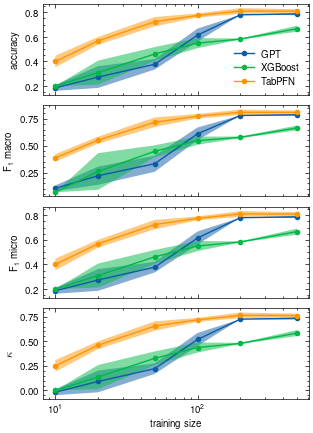

In [24]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex='all')

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
    ax[i].plot(
        grouped_res.loc[5,:].index,
        grouped_res.loc[5,:][metric]['mean'],
        marker='o',
        label='GPT',
    )
    ax[i].fill_between(
        grouped_res.loc[5,:].index,
        grouped_res.loc[5,:][metric]['mean'] - grouped_res.loc[5,:][metric]['std'],
        grouped_res.loc[5,:][metric]['mean'] + grouped_res.loc[5,:][metric]['std'],
        alpha=0.5,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[5,:].index,
        grouped_xgboost_res.loc[5,:][metric]['mean'],
        marker='o',
        label='XGBoost'
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[5,:].index,
        grouped_xgboost_res.loc[5,:][metric]['mean'] - grouped_xgboost_res.loc[5,:][metric]['std'],
        grouped_xgboost_res.loc[5,:][metric]['mean'] + grouped_xgboost_res.loc[5,:][metric]['std'],
        alpha=0.5,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[5,:].index,
        grouped_tabpfn_res.loc[5,:][metric]['mean'],
        marker='o',
        label='TabPFN'
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[5,:].index,
        grouped_tabpfn_res.loc[5,:][metric]['mean'] - grouped_tabpfn_res.loc[5,:][metric]['std'],
        grouped_tabpfn_res.loc[5,:][metric]['mean'] + grouped_tabpfn_res.loc[5,:][metric]['std'],
        alpha=0.5,
    )

ax[-1].set_xlabel('training size')
ax[0].legend()

ax[0].set_ylabel('accuracy')
ax[1].set_ylabel(r'F$_{1}$ macro')
ax[2].set_ylabel(r'F$_{1}$ micro')
ax[3].set_ylabel(r'$\kappa$')
ax[0].set_xscale('log')

fig.tight_layout()
fig.savefig('polymner-classification_results_5.pdf', bbox_inches='tight')